Using cache found in /home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main
/mnt/ceph_vol/miniconda3/envs/dinov2/lib/python3.9/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


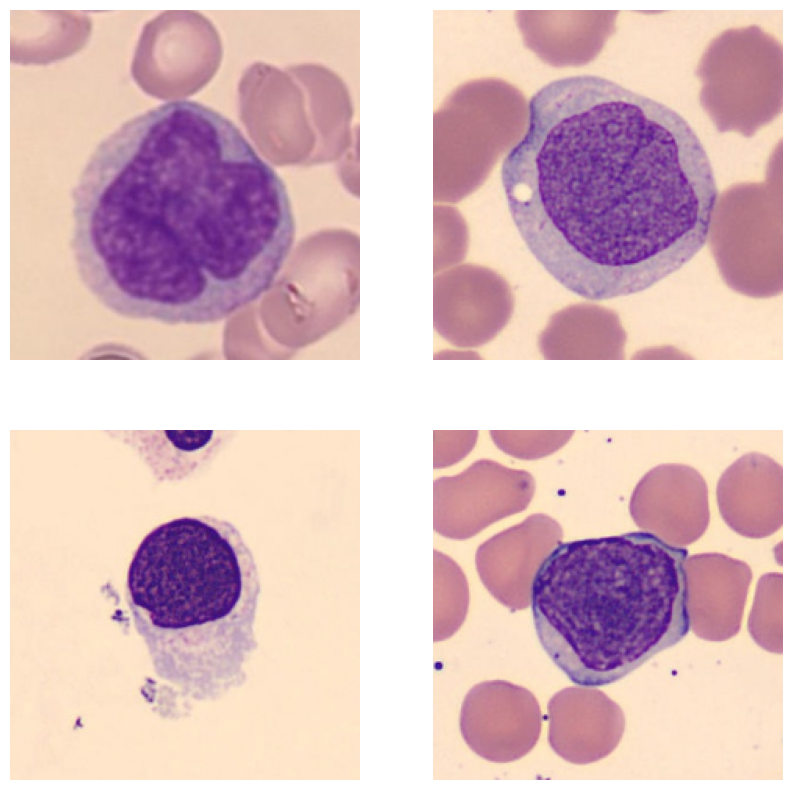

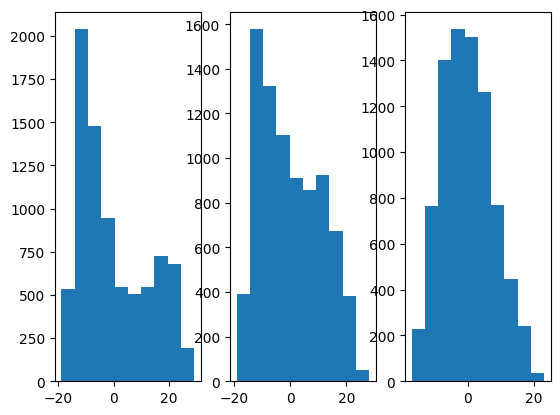

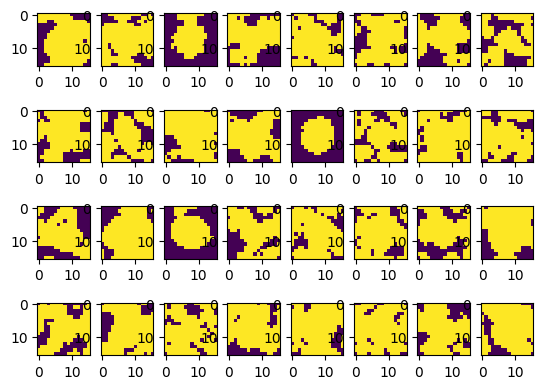

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


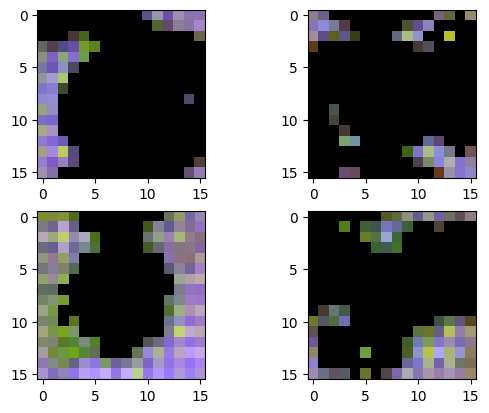

In [1]:
import torch
import torchvision.transforms as T

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pathlib import Path
# PCA for feature inferred
from sklearn.decomposition import PCA

patch_h = 16
patch_w = 16
feat_dim = 384 # vits14
#feat_dim = 768 # vitb14
#feat_dim = 1024 # vitl14
#feat_dim = 1536 # vitg14
img_size=224
batch_size=32
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
# dinov2_vitb14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
# dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
#dinov2_vitg14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')


paths=list(Path("/mnt/ceph_vol/segmentation_WBC/Dataset 2").glob("*.bmp"))[:batch_size]

# Modify the list comprehension to move each image tensor to CUDA
imgs_tensor = torch.stack([transform(Image.open(img_path).convert('RGB').resize((img_size,img_size))).cuda() for img_path in paths])

# Move your model to GPU
dinov2_vits14.cuda()

with torch.no_grad():
    # Ensure the input tensor is on GPU by calling .cuda() on it
    features_dict = dinov2_vits14.forward_features(imgs_tensor)
    features = features_dict['x_norm_patchtokens']




features = features.reshape(len(paths) * patch_h*patch_h, feat_dim).cpu().numpy()

pca = PCA(n_components=3)
pca.fit(features)
pca_features = pca.transform(features)

images_for_plotting = [Image.open(img_path).convert('RGB').resize((img_size, img_size)) for img_path in paths[:batch_size]]

# Plotting the images in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, ax in enumerate(axs.flat):
    ax.imshow(images_for_plotting[i])
    ax.axis('off')  # Remove axis
plt.show()
plt.close()
# visualize PCA components for finding a proper threshold
plt.subplot(1, 3, 1)
plt.hist(pca_features[:, 0])
plt.subplot(1, 3, 2)
plt.hist(pca_features[:, 1])
plt.subplot(1, 3, 3)
plt.hist(pca_features[:, 2])
plt.show()
plt.close()

# uncomment below to plot the first pca component
# pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / (pca_features[:, 0].max() - pca_features[:, 0].min())
# for i in range(4):
#     plt.subplot(2, 2, i+1)
#     plt.imshow(pca_features[i * patch_h * patch_w: (i+1) * patch_h * patch_w, 0].reshape(patch_h, patch_w))
# plt.show()
# plt.close()

# segment using the first component
pca_features_bg = pca_features[:, 0] < 10
pca_features_fg = ~pca_features_bg

# plot the pca_features_bg
for i in range(batch_size):
    plt.subplot(4, int(batch_size/4), i+1)
    plt.imshow(pca_features_bg[i * patch_h*patch_w: (i+1) * patch_h*patch_w].reshape(patch_h, patch_w))
plt.show()

# PCA for only foreground patches
pca_features_rem = pca.transform(features[pca_features_fg])
for i in range(3):
    # pca_features_rem[:, i] = (pca_features_rem[:, i] - pca_features_rem[:, i].min()) / (pca_features_rem[:, i].max() - pca_features_rem[:, i].min())
    # transform using mean and std, I personally found this transformation gives a better visualization
    pca_features_rem[:, i] = (pca_features_rem[:, i] - pca_features_rem[:, i].mean()) / (pca_features_rem[:, i].std() ** 2) + 0.5

pca_features_rgb = pca_features.copy()
pca_features_rgb[pca_features_bg] = 0
pca_features_rgb[pca_features_fg] = pca_features_rem

pca_features_rgb = pca_features_rgb.reshape(batch_size, patch_h, patch_w, 3)
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_rgb[i][..., ::-1])
plt.savefig('features.png')
plt.show()
plt.close()